# Herschel Stripe 82 master catalogue
## Preparation of VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera data

VISTA/CFHT Telescope / VIRCAM/WIRCAM Camera VICS82 catalogue: the catalogue comes from `dmu0_VICS82`.

The catalogue is described here: https://arxiv.org/pdf/1705.05451.pdf

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band.
- The auto magnitude to be used as total magnitude .



In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
9df0d27 (Wed Jun 7 13:33:34 2017 +0100) [with local modifications]


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "vics82_ra"
DEC_COL = "vics82_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
        'VICS82ID': "vics82_id",
        'ra': "vics82_ra",
        'dec': "vics82_dec",
        'CLASS_STAR':  "vics82_stellarity",
        'MAG_AUTO': "m_vics82_k", 
        'MAG_APER': "m_ap_vics82_k", 
        'JMAG_AUTO': "m_vics82_j", 
        'JMAG_APER': "m_ap_vics82_j", 
})

#No error column?

catalogue = Table.read("../../dmu0/dmu0_VICS82/data/VICS82_FULL_SDSS_FEB2017_K22_HELP-coverage_intIDs.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2011

# Clean table metadata
catalogue.meta = None

#replace list of aperture magnitudes with appropriate choice from list
# Apertures (1", 1.5", 2", 2.5" and 3"
catalogue["m_ap_vics82_j"] = catalogue["m_ap_vics82_j"][:, 2]
catalogue["m_ap_vics82_j"] = catalogue["m_ap_vics82_j"][:, 2]


In [5]:
# Adding flux and band-flag columns
for col in catalogue.colnames:
    if col.startswith('m_'):
        
        # Add err col with all nan values because errors absent
        errcol = "merr{}".format(col[1:])
        nan_values = np.empty(len(catalogue))
        nan_values[:] = np.NAN
        catalogue.add_column(Column(nan_values, name=errcol))
        
        # Some object have a magnitude to 0, we suppose this means missing value
        catalogue[col][catalogue[col] <= 0] = np.nan
        catalogue[errcol][catalogue[errcol] <= 0] = np.nan  
        

        flux, error = mag_to_flux(np.array(catalogue[col]), np.array(catalogue[errcol]))
        
        # Fluxes are added in µJy
        catalogue.add_column(Column(flux * 1.e6, name="f{}".format(col[1:])))
        catalogue.add_column(Column(error * 1.e6, name="f{}".format(errcol[1:])))
        
        # Band-flag column
        if "ap" not in col:
            catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[1:])))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in less_equal
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in less_equal


In [6]:
catalogue[:10].show_in_notebook()

idx,wfc_id,wfc_ra,wfc_dec,wfc_stellarity,m_app_wfc_u,merr_app_wfc_u,m_wfc_u,merr_wfc_u,m_app_wfc_g,merr_app_wfc_g,m_wfc_g,merr_wfc_g,m_app_wfc_r,merr_app_wfc_r,m_wfc_r,merr_wfc_r,m_app_wfc_i,merr_app_wfc_i,m_wfc_i,merr_wfc_i,m_app_wfc_z,merr_app_wfc_z,m_wfc_z,merr_wfc_z,f_app_wfc_u,ferr_app_wfc_u,f_wfc_u,ferr_wfc_u,flag_wfc_u,f_app_wfc_g,ferr_app_wfc_g,f_wfc_g,ferr_wfc_g,flag_wfc_g,f_app_wfc_r,ferr_app_wfc_r,f_wfc_r,ferr_wfc_r,flag_wfc_r,f_app_wfc_i,ferr_app_wfc_i,f_wfc_i,ferr_wfc_i,flag_wfc_i,f_app_wfc_z,ferr_app_wfc_z,f_wfc_z,ferr_wfc_z,flag_wfc_z
0,189636200346,240.538272005,55.885030264,0.000171437,23.875,0.235,23.997,0.488,22.656,0.045,22.623,0.052,21.355,0.037,21.453,0.037,21.057,0.05,21.187,0.046,20.648,0.084,20.799,0.088,1.02329,0.221484,0.914534,0.411051,False,3.14485,0.130343,3.24191,0.155267,False,10.4232,0.355204,9.52358,0.324547,False,13.7151,0.631606,12.1675,0.515506,False,19.9894,1.54652,17.394,1.40980223659,False
1,189636201299,240.616100794,55.770734294,0.00306748,nan,nan,nan,nan,24.079,0.22,23.528,0.2,23.23,0.18,23.004,0.204,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,0.848007,0.17183,1.40864,0.259481,False,1.85353,0.30729,2.28244,0.42885,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
2,189636201298,240.703609131,55.770877382,0.486486,nan,nan,nan,nan,23.967,0.199,23.985,0.256,23.534,0.238,23.476,0.339,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,0.940157,0.172317,0.924697,0.218029,False,1.40088,0.30708,1.47775,0.461398,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False
3,189636201297,240.584109531,55.770868417,0.00306748,nan,nan,nan,nan,nan,nan,nan,nan,22.724,0.114,22.623,0.183,22.442,0.15,22.371,0.273,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,nan,nan,False,2.95392,0.310156,3.24191,0.546421,False,3.83001,0.529136,4.08884,1.02811,False,nan,nan,nan,nan,False
4,189636201296,240.641668965,55.771558572,9.52581e-06,nan,nan,nan,nan,22.192,0.049,22.195,0.057,21.069,0.031,21.128,0.032,20.517,0.038,20.476,0.042,20.227,0.064,20.211,0.076,nan,nan,nan,nan,False,4.8217,0.217606,4.8084,0.252436,False,13.5644,0.387291,12.8469,0.378639,False,22.5528,0.789331,23.4207,0.905993,False,29.4578,1.73642,29.8951,2.09261364216,False
5,189636201295,240.487648046,55.77129696,9.52581e-06,nan,nan,nan,nan,23.386,0.12,23.341,0.193,22.299,0.079,22.372,0.082,21.476,0.067,21.526,0.07,21.323,0.125,21.384,0.137,nan,nan,nan,nan,False,1.60546,0.177442,1.6734,0.297463,False,4.36918,0.317909,4.08507,0.308524,False,9.32395,0.575374,8.90431,0.574082,False,10.7349,1.23591,10.1484,1.28054794823,False
6,189636201294,240.583398397,55.771571316,5.29221e-07,22.491,0.075,22.642,0.069,21.809,0.041,21.788,0.05,21.206,0.033,21.17,0.043,20.942,0.047,20.89,0.058,20.895,0.091,20.626,0.131,3.661,0.252893,3.18566,0.202453,False,6.8612,0.259095,6.9952,0.322141,False,11.9564,0.363404,12.3595,0.48949,False,15.2475,0.660045,15.9956,0.854483,False,15.9221,1.33449,20.3986,2.46119958865,False
7,189636201293,240.630510173,55.771586358,0.999657,nan,nan,nan,nan,23.753,0.165,23.873,0.141,23.248,0.183,23.313,0.116,22.989,0.245,23.259,0.216,nan,nan,nan,nan,nan,nan,nan,nan,False,1.14498,0.174004,1.02518,0.133136,False,1.82306,0.307275,1.71712,0.183457,False,2.31419,0.522206,1.80468,0.359029,False,nan,nan,nan,nan,False
8,189636201292,240.412675797,55.771168243,9.52581e-06,nan,nan,nan,nan,22.929,0.082,22.749,0.104,22.073,0.065,21.864,0.099,21.955,0.086,22.033,0.108,21.564,0.152,21.538,0.162,nan,nan,nan,nan,False,2.44568,0.184709,2.88669,0.276509,False,5.38022,0.322098,6.52228,0.594717,False,5.99791,0.475088,5.58212,0.555263,False,8.59805,1.2037,8.80643,1.31398556368,False
9,189636201291,240.430102013,55.771330883,0.996753,nan,nan,nan,nan,21.9,0.042,21.953,0.046,20.841,0.027,20.948,0.026,19.587,0.029,19.681,0.029,18.917,0.051,19.012,0.052,nan,nan,nan,nan,False,6.30958,0.244076,6.00897,0.254585,False,16.734,0.41614,15.1635,0.363119,False,53.1129,1.41864,48.708,1.30099,False,98.4464,4.6243,90.1987,4.31995483814,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [7]:
SORT_COLS = ['m_ap_vics82_j', 'm_ap_vics82_k']
FLAG_NAME = 'vics82_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

The initial catalogue had 1143872 sources.
The cleaned catalogue has 1143463 sources (409 removed).
The cleaned catalogue has 409 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [8]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_Herschel-Stripe-82.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

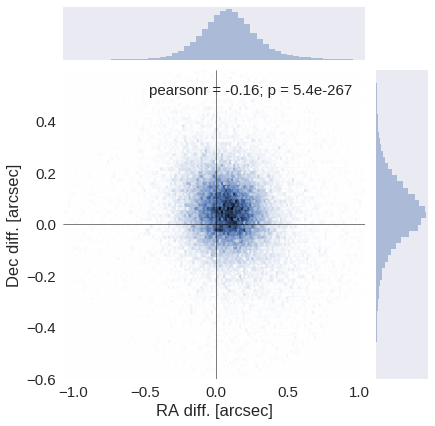

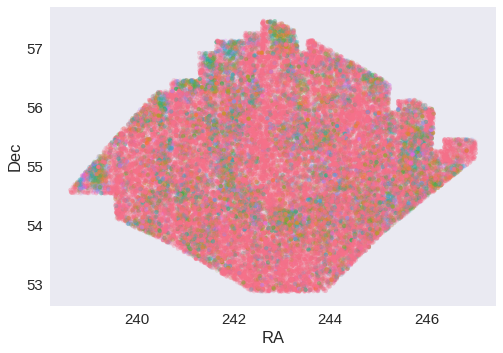

In [9]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [10]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: -0.084394594762216 arcsec
Dec correction: -0.04639860251529626 arcsec


In [11]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

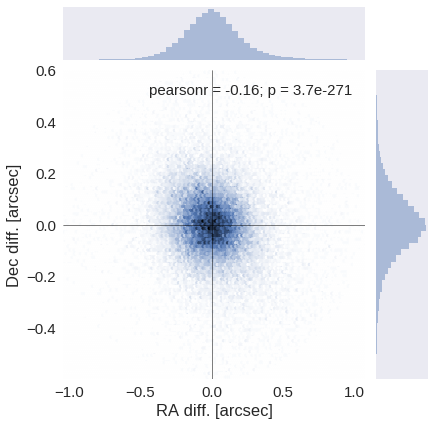

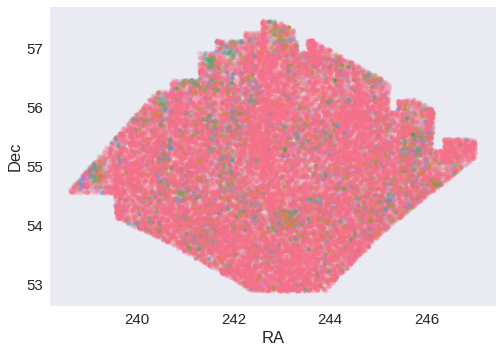

In [12]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [13]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [14]:
GAIA_FLAG_NAME = "vics82_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

52542 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [15]:
catalogue.write("{}/VICS82.fits".format(OUT_DIR), overwrite=True)